# Natural Language Processing (NLP)

### Word Embeddings (Word Vectors)

A mapping words from a vocabulary into a low-dimensional space, where words with similar meanings are close together. 

Use ConceptNet Numberbatch for their pre-trained word vectors to get used to its properties.

They use h5 as the format. Need to install `h5py` if haven't.


In [3]:
# Download word vectors
from urllib.request import urlretrieve
import os

if not os.path.isfile('datasets/mini.h5'):
    print("Downloading Conceptnet Numberbatch word embeddings...")
    conceptnet_url = 'http://conceptnet.s3.amazonaws.com/precomputed-data/2016/numberbatch/17.06/mini.h5'
    urlretrieve(conceptnet_url, 'datasets/mini.h5')

Open the `mini.h5` file. 
We extract from the file a list of utf-8-encoded words, as well as their 300-d vectors.

In [4]:
# Load the file and pull out words and embeddings
import h5py

with h5py.File('datasets/mini.h5', 'r') as f:
    all_words = [word.decode('utf-8') for word in f['mat']['axis1'][:]]
    all_embeddings = f['mat']['block0_values'][:]
    
print("all_words dimensions: {}".format(len(all_words)))
print("all_embeddings dimensions: {}".format(all_embeddings.shape))

print("Random example word: {}".format(all_words[1337]))

all_words dimensions: 362891
all_embeddings dimensions: (362891, 300)
Random example word: /c/de/aufmachung


`all_words` is a list of $V$ strings (what we call our *vocabulary*), and `all_embeddings` is a $V \times 300$ matrix. The strings are of the form `/c/language_code/word`—for example, `/c/en/cat` and `/c/es/gato`.

Extract only English words:

In [5]:
# Restrict our vocabulary to just the English words
english_words = [word[6:] for word in all_words if word.startswith('/c/en/')]
english_word_indices = [i for i, word in enumerate(all_words) if word.startswith('/c/en/')]
english_embeddings = all_embeddings[english_word_indices]

print("Number of English words in all_words: {0}".format(len(english_words)))
print("english_embeddings dimensions: {0}".format(english_embeddings.shape))

print(english_words[1337])

Number of English words in all_words: 150875
english_embeddings dimensions: (150875, 300)
activated_carbon


The magnitude of a word vector can be thought of as representing frequency of use, independent of the semantics of the word. 

We have to *normalize* vectors, dividing each by its length. 
The result is that all of our word vectors are length 1, and as such, lie on a unit circle. 
The dot product of two vectors is proportional to the cosine of the angle between them, and provides a measure of similarity (the bigger the cosine, the smaller the angle).

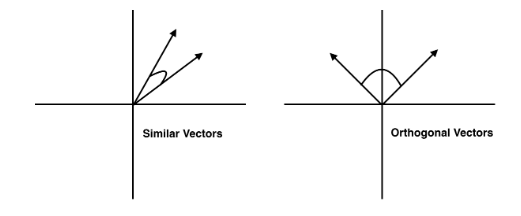

In [6]:
import numpy as np

norms = np.linalg.norm(english_embeddings, axis=1)
normalized_embeddings = english_embeddings.astype('float32') / norms.astype('float32').reshape([-1, 1])

We want to look up words easily, so we create a dictionary that maps us from a word to its index in the word embeddings matrix.

In [7]:
index = {word: i for i, word in enumerate(english_words)}

Measure similarity between pairs of words by taking dot products of 2 vectors:

In [8]:
def similarity_score(w1, w2):
    score = np.dot(normalized_embeddings[index[w1], :], normalized_embeddings[index[w2], :])
    return score

# A word is as similar with itself as possible:
print('cat\tcat\t', similarity_score('cat', 'cat'))

# Closely related words still get high scores:
print('cat\tfeline\t', similarity_score('cat', 'feline'))
print('cat\tdog\t', similarity_score('cat', 'dog'))

# Unrelated words, not so much
print('cat\tmoo\t', similarity_score('cat', 'moo'))
print('cat\tfreeze\t', similarity_score('cat', 'freeze'))

# Antonyms are still considered related, sometimes more so than synonyms
print('antonym\topposite\t', similarity_score('antonym', 'opposite'))
print('antonym\tsynonym\t', similarity_score('antonym', 'synonym'))

cat	cat	 1.0
cat	feline	 0.8199548
cat	dog	 0.590724
cat	moo	 0.0039538266
cat	freeze	 -0.030225186
antonym	opposite	 0.3941065
antonym	synonym	 0.46883982


Can also find the most similar words to a given word:

In [9]:
def closest_to_vector(v, n):
    all_scores = np.dot(normalized_embeddings, v)
    best_words = list(map(lambda i: english_words[i], reversed(np.argsort(all_scores))))
    return best_words[:n]

def most_similar(w, n):
    return closest_to_vector(normalized_embeddings[index[w], :], n)

print(most_similar('cat', 10))
print(most_similar('dog', 10))
print(most_similar('duke', 10))

['cat', 'humane_society', 'kitten', 'feline', 'colocolo', 'cats', 'kitty', 'maine_coon', 'housecat', 'sharp_teeth']
['dog', 'dogs', 'wire_haired_dachshund', 'doggy_paddle', 'lhasa_apso', 'good_friend', 'puppy_dog', 'bichon_frise', 'woof_woof', 'golden_retrievers']
['duke', 'dukes', 'duchess', 'duchesses', 'ducal', 'dukedom', 'duchy', 'voivode', 'princes', 'prince']


Can also use `closest_to_vector` to find words "nearby" vectors that we create ourselves. This allows us to solve analogies. 

For example, in order to solve the analogy "man : brother :: woman : ?", we can compute a new vector `brother - man + woman`: the meaning of brother, minus the meaning of man, plus the meaning of woman. We can then ask which words are closest, in the embedding space, to that new vector.

<sup>* Results might not be perfect</sup>

In [10]:
def solve_analogy(a1, b1, a2):
    b2 = normalized_embeddings[index[b1], :] - normalized_embeddings[index[a1], :] + normalized_embeddings[index[a2], :]
    return closest_to_vector(b2, 1)

print(solve_analogy("man", "brother", "woman"))
print(solve_analogy("man", "husband", "woman"))
print(solve_analogy("spain", "madrid", "france"))
print(solve_analogy("bird", "wing", "fish"))
print(solve_analogy("cat", "kitten", "dog"))
print(solve_analogy("fire", "hot", "ice"))

['sister']
['wife']
['paris']
['fish']
['dog']
['ice']


### Using embeddings in models

Primary use of word embeddings is that they allow us to think of words as existing in a continuous, Euclidean space; then can use machine learning with continuous numerical data (like logistic regression or neural networks) to process text.

To demonstrate this perform sentiment analysis on movie reviews.

Use a [Simple Word Embedding Model](http://people.ee.duke.edu/~lcarin/acl2018_swem.pdf) (SWEM, Shen et al. 2018) to do so. 
We will represent a review as the mean of the embeddings of the words in the review. 
Then we'll train a two-layer MLP (a neural network) to classify the review as positive or negative.

Download the `movie-simple.txt` file. 
Each line of that file contains 

1. the numeral 0 (for negative) or the numeral 1 (for positive), followed by
2. a tab (the whitespace character), and then
3. the review itself.

In [11]:
import string
remove_punct=str.maketrans('','',string.punctuation)

# This function converts a line of our data file into
# a tuple (x, y), where x is 300-dimensional representation
# of the words in a review, and y is its label.
def convert_line_to_example(line):
    # Pull out the first character: that's our label (0 or 1)
    y = int(line[0])
    
    # Split the line into words using Python's split() function
    words = line[2:].translate(remove_punct).lower().split()
    
    # Look up the embeddings of each word, ignoring words not
    # in our pretrained vocabulary.
    embeddings = [normalized_embeddings[index[w]] for w in words
                  if w in index]
    
    # Take the mean of the embeddings
    x = np.mean(np.vstack(embeddings), axis=0)
    return x, y

# Apply the function to each line in the file.
xs = []
ys = []
with open("datasets/movie-simple.txt", "r", encoding='utf-8', errors='ignore') as f:
    for l in f.readlines():
        x, y = convert_line_to_example(l)
        xs.append(x)
        ys.append(y)

# Concatenate all examples into a numpy array
xs = np.vstack(xs)
ys = np.vstack(ys)

print("Shape of inputs: {}".format(xs.shape))
print("Shape of labels: {}".format(ys.shape))

num_examples = xs.shape[0]

Shape of inputs: (1411, 300)
Shape of labels: (1411, 1)


Like this, input words have been converted to vectors as part of our preprocessing.
This essentially locks our word embeddings in place throughout training, as opposed to learning the word embeddings.

Learning word embeddings from scratch/fine-tuned from pre-trained initialization is often better as it is more specialized, but not needed here as dataset is small.

Next, split data into test/train set, then convert to tensors:

In [12]:
import torch

# Shuffle the data
print("First 20 labels before shuffling: {0}".format(ys[:20, 0]))

shuffle_idx = np.random.permutation(num_examples)
xs = xs[shuffle_idx, :]
ys = ys[shuffle_idx, :]

print("First 20 labels after shuffling: {0}".format(ys[:20, 0]))

# Split the data into training and test sets (80-20)
num_train = 4*num_examples // 5

x_train = torch.tensor(xs[:num_train])
y_train = torch.tensor(ys[:num_train], dtype=torch.float32)

x_test = torch.tensor(xs[num_train:])
y_test = torch.tensor(ys[num_train:], dtype=torch.float32)

First 20 labels before shuffling: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
First 20 labels after shuffling: [1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1]


Create a TensorDataset and DataLoader (like in MNIST):

In [13]:
reviews_train = torch.utils.data.TensorDataset(x_train, y_train)
reviews_test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(reviews_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(reviews_test, batch_size=100, shuffle=False)

#### Building SVEM Model:

Notice that number of outputs for our MLP can be made to 2 (1 each for diff output classes positive/negative).
However, since we only have two output classes here, we can instead produce a single output value, calling everything greater than $0$ "postive" and everything less than $0$ "negative".

Then pass this output through a sigmoid operation, values are mapped to $[0,1]$, with $0.5$ being the classification threshold.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SWEM(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Training the model:

Notice that since we are doing binary classification we use binary cross-entropy (BCE) loss instead of cross-entropy loss, and we use "with logits" version for numerical stability.

In [15]:
## Training
# Instantiate model
model = SWEM()

# Binary cross-entropy (BCE) Loss and Adam Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Iterate through train set minibatchs 
for epoch in range(250):
    correct = 0
    num_examples = 0
    for inputs, labels in train_loader:
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y = model(inputs)
        loss = criterion(y, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        predictions = torch.round(torch.sigmoid(y))
        correct += torch.sum((predictions == labels).float())
        num_examples += len(inputs)
    
    # Print training progress
    if epoch % 25 == 0:
        acc = correct/num_examples
        print("Epoch: {0} \t Train Loss: {1} \t Train Acc: {2}".format(epoch, loss, acc))

## Testing
correct = 0
num_test = 0

with torch.no_grad():
    # Iterate through test set minibatchs 
    for inputs, labels in test_loader:
        # Forward pass
        y = model(inputs)
        
        predictions = torch.round(torch.sigmoid(y))
        correct += torch.sum((predictions == labels).float())
        num_test += len(inputs)
    
print('Test accuracy: {}'.format(correct/num_test))

Epoch: 0 	 Train Loss: 0.6989526748657227 	 Train Acc: 0.539893627166748
Epoch: 25 	 Train Loss: 0.14925622940063477 	 Train Acc: 0.9459219574928284
Epoch: 50 	 Train Loss: 0.09281475841999054 	 Train Acc: 0.9707446694374084
Epoch: 75 	 Train Loss: 0.149235337972641 	 Train Acc: 0.9769503474235535
Epoch: 100 	 Train Loss: 0.06615883111953735 	 Train Acc: 0.9804964661598206
Epoch: 125 	 Train Loss: 0.03409971669316292 	 Train Acc: 0.9831560254096985
Epoch: 150 	 Train Loss: 0.08047468215227127 	 Train Acc: 0.9858155846595764
Epoch: 175 	 Train Loss: 0.10049691051244736 	 Train Acc: 0.991134762763977
Epoch: 200 	 Train Loss: 0.026480156928300858 	 Train Acc: 0.993794322013855
Epoch: 225 	 Train Loss: 0.026486586779356003 	 Train Acc: 0.9955673813819885
Test accuracy: 0.9611307382583618


Testing model:

In [16]:
import torch

words_to_test = ["exciting", "hated", "boring", "loved", "alright", "decent", "terrible", "awesome"]

for word in words_to_test:
    x = torch.tensor(normalized_embeddings[index[word]].reshape(1, 300))
    sigmoid_output = torch.sigmoid(model(x)).item() # model(x) returns a tensor, .item() gets the float value
    
    if sigmoid_output < 0.3:
        sentiment = "negative"
    elif sigmoid_output > 0.7:
        sentiment = "positive"
    else:
        sentiment = "neutral"
    
    print("Sentiment of the word '{0}': {1} (sigmoid output: {2})".format(word, sentiment, sigmoid_output))


Sentiment of the word 'exciting': positive (sigmoid output: 0.9999997615814209)
Sentiment of the word 'hated': negative (sigmoid output: 6.418668360615355e-23)
Sentiment of the word 'boring': negative (sigmoid output: 1.2959721552637778e-17)
Sentiment of the word 'loved': positive (sigmoid output: 1.0)
Sentiment of the word 'alright': negative (sigmoid output: 0.06384996324777603)
Sentiment of the word 'decent': negative (sigmoid output: 0.01869584619998932)
Sentiment of the word 'terrible': negative (sigmoid output: 7.299112552507866e-19)
Sentiment of the word 'awesome': positive (sigmoid output: 1.0)


### Learning Word Embeddings

Pre-trained word embeddings are typically trained on large corpora with unsupervised objectives, and are often non-specific.
If we have enough data, we may prefer to learn the word embeddings, either from scratch or with fine-tuning, as making them specific to the task may improve performance.

To learn word embeddings we need to make them a part of our model, rather than as part of loading the data.

Use `nn.Embedding`.

Like the other `nn` layers we've seen (e.g. `nn.Linear`), `nn.Embedding` must be instantiated first. 

There are two required arguments for instantiation: number of embeddings (i.e. the vocabulary size $V$) and the dimension of word embeddings (300, in our previous example).

In [17]:
VOCAB_SIZE = 5000
EMBED_DIM = 300

embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)

embedding.weight.size()

torch.Size([5000, 300])

This creates a word embedding matrix that is $5000 \times 300$, basically a 300 dimensional word embedding for each of the 5000 words, stacked on top of each other.
Looking up a word embedding in this embedding matrix is simply selecting a specific row of this matrix, corresponding to the word.

When word embeddings are learned, `nn.Embedding` look-up is often one of the first operations in a model module.
For example, if we were to learn the word embeddings for our previous SWEM model, the model might instead look like this:

* Note that the expected input to the `forward()` function is now the word tokens for the input sentence, so we would have to modify our data input pipeline as well.

In [18]:
class SWEMWithEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, num_outputs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_outputs)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=0)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    

# size of layers have been abstracted out to the constructor
model = SWEMWithEmbeddings(
    vocab_size = 5000,
    embedding_size = 300, 
    hidden_dim = 64, 
    num_outputs = 1,
)
print(model)

SWEMWithEmbeddings(
  (embedding): Embedding(5000, 300)
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


### Recurrent Neural Networks (RNNs)

Sequential data is commonly modeled with RNNs. Since natural language is viewed as a sequence of words, RNNs are commonly used for NLP.

RNNs use combinations of linear and nonlinear transformations to project input into higher level representations, and these representations can be stacked with additional layers.

#### Sentences as Sequences

Difference between sequential models and the other models we've seen is the presence of a "time" dimension: words in a sentence (or paragraph, document) have an ordering to them that convey meaning:

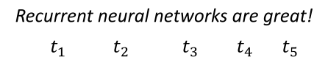

In the example sequence above, the word "Recurrent" is the $t=1$ word, which we denote $w_1$; similarly, "neural" is $w_2$, and so on.

It is advantageous to model words as embedding vectors $x_1, ..., x_T$, rather than one-hot vectors (which tokens $w_1,...w_T$ correspond to), so our first step is often to do an embedding table look-up for each input word.

Assume 300-dimensional word embeddings and, for simplicity, a minibatch of size 1.

In [19]:
mb = 1
x_dim = 300 
sentence = ["recurrent", "neural", "networks", "are", "great"]

xs = []
for word in sentence:
    xs.append(torch.tensor(normalized_embeddings[index[word]]).view(1, x_dim))
    
xs = torch.stack(xs, dim=0)
print("xs shape: {}".format(xs.shape))

xs shape: torch.Size([5, 1, 300])


Notice that we have formatted our inputs as ($\text{words} \times \text{minibatch} \times \text{embedding dimension}$).
This is the preferred input ordering for PyTorch RNNs.

Let's say we want to process this example.
In our previous sentiment analysis example, we just took the average embedding across time, treating the input as a "bag-of-words."
For simple problems, this can work surprisingly well, but as you might imagine, the ordering of words in a sentence is often important, and sometimes, we'd like to be able to model this temporal meaning as well.
Enter RNNs.


#### Fully Connected Layer

Notation has been changed from logistic regression/MLP:

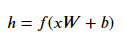

Instead of calling the result of the fully connected layer $y$, we call it $h$, for hidden state.
The variable $y$ is usually reserved for the final layer of the neural network; since logistic regression was a single layer, using $y$ was fine. 

However, if we assume there is more than one layer, it is more common to refer to the intermediate representation as $h$.
Note that we also use $f()$ to denote a nonlinear activation function.
In the past, we've seen $f()$ as a $\text{ReLU}$, but this could also be a $\sigma()$ or $\tanh()$ nonlinearity.
Visualized:

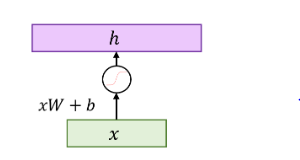

We project the input $x$ with a linear transformation (with $W$ and $b$), and then apply a nonlinearity to the output, giving us $h$.
During training, our goal is to learn $W$ and $b$.


#### Basic RNN

Sequential data have multiple inputs $x_1, ..., x_T$, instead of a single $x$ so
we need to adapt our models accordingly for an RNN.
While there are several variations, a common basic formulation for an RNN is the Elman RNN:

\begin{align}
h_t = \tanh((x_t W_x + b_x) + (h_{t-1} W_h + b_h))
\end{align}

where $\tanh()$ is the hyperbolic tangent, a nonlinear activation function.
RNNs process words one at a time in sequence ($x_t$), producing a hidden state $h_t$ at every time step.
The first half of the above equation should look familiar; as with the fully connected layer, we are linearly transforming each input $x_t$, and then applying a nonlinearity.
Notice that we apply the same linear transformation ($W_x$, $b_x$) at every time step.
The difference is that we also apply a separate linear transform ($W_h$, $b_h$) to the previous hidden state $h_{t-1}$ and add it to our projected input.
This feedback is called a *recurrent* connection.

These directed cycles in the RNN architecture gives them the ability to model temporal dynamics, making them particularly suited for modeling sequences (e.g. text).
We can visualize an RNN layer as follows:

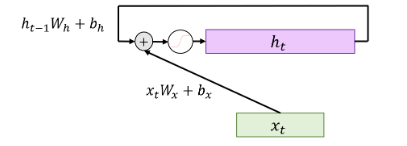

Showing multiple sequences:

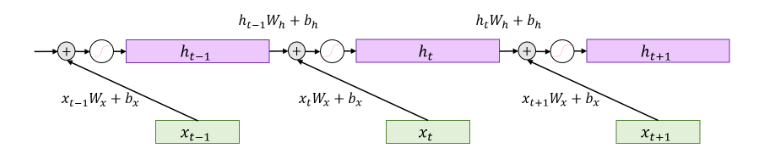

These recurrent connections allows the model to consider previous hidden states of a sequence when calculating the hidden state for the current input.

<font size="1">&ast;Note: We don't actually need two separate biases $b_x$ and $b_h$, as you can combine both biases into a single learnable parameter $b$. 
However, writing it separately helps make it clear that we're performing a linear transformation on both $x_t$ and $h_{t-1}$.
Speaking of combining variables, we can also express the above operation by concatenating $x_t$ and $h_{t-1}$ into a single vector $z_t$, and then performing a single matrix multiply $z_t W_z + b$, where $W_z$ is essentially $W_x$ and $W_h$ concatenated.
Indeed this is how many "official" RNNs modules are implemented, as the reduction in the number of separate matrix multiply operations makes it computationally more effecient.
These are implementation details though.</font>

#### RNN in PyTorch

In an RNN, we project both the input $x_t$ and the previous hidden state $h_{t-1}$ to some hidden dimension, which we choose to be 128.
To perform these operations, we're going to define some variables we're going to learn:

In [20]:
import numpy as np
import torch

h_dim = 128 # hidden dimension size of the RNN

# For projecting the input
Wx = torch.randn(x_dim, h_dim)/np.sqrt(x_dim)
Wx.requires_grad_()
bx = torch.zeros(h_dim, requires_grad=True)

# For projecting the previous state
Wh = torch.randn(h_dim, h_dim)/np.sqrt(h_dim)
Wh.requires_grad_()
bh = torch.zeros(h_dim, requires_grad=True)

print(Wx.shape, bx.shape, Wh.shape, bh.shape)

torch.Size([300, 128]) torch.Size([128]) torch.Size([128, 128]) torch.Size([128])


For convenience, we define a function for one time step of the RNN.
This function take the current input $x_t$ and previous hidden state $h_{t-1}$, performs the linear transformations $x W_x + b_x$ and $h W_h + b_h$, and then a hyperbolic tangent nonlinearity.

In [21]:
def RNN_step(x, h):
    h_next = torch.tanh((torch.matmul(x, Wx) + bx) + (torch.matmul(h, Wh) + bh))

    return h_next

Each step of our RNN is going to require feeding in an input (i.e. the word representation) and the previous hidden state (the summary of preceding sequence). Note that at the beginning of a sentence, we don't have a previous hidden state, so we initialize it to some value, for example all zeros:

In [22]:
# Word embedding for first word
x1 = xs[0, :, :]

# Initialize hidden state to 0
h0 = torch.zeros([mb, h_dim])

To take one time step of the RNN, we call the function we wrote, passing in $x_1$ and $h_0$:

In [23]:
# Forward pass of one RNN step for time step t=1
h1 = RNN_step(x1, h0)

print("Hidden state h1 dimensions: {0}".format(h1.shape))

Hidden state h1 dimensions: torch.Size([1, 128])


Then call the `RNN_step` function again to get the next time step output from our RNN.

In [24]:
# Word embedding for second word
x2 = xs[1, :, :]

# Forward pass of one RNN step for time step t=2
h2 = RNN_step(x2, h1)

print("Hidden state h2 dimensions: {0}".format(h2.shape))

Hidden state h2 dimensions: torch.Size([1, 128])


We can continue unrolling the RNN as far as we need to. 
For each step, we feed in the current input ($x_t$) and previous hidden state ($h_{t-1}$) to get a new output.

However instead of doing it manually use `torch.nn`:

In [25]:
import torch.nn

rnn = nn.RNN(x_dim, h_dim)
print("RNN parameter shapes: {}".format([p.shape for p in rnn.parameters()]))

hs, h_T = rnn(xs) # pass entire input sequence xs, returns all hidden states and the final hidden state

print("Hidden states shape: {}".format(hs.shape))
print("Final hidden state shape: {}".format(h_T.shape))

RNN parameter shapes: [torch.Size([128, 300]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128])]
Hidden states shape: torch.Size([5, 1, 128])
Final hidden state shape: torch.Size([1, 1, 128])


What do we do with these hidden states?
It depends on the model and task.
Just like multilayer perceptrons and convolutional neural networks, RNNs can be stacked in multiple layers as well.
In this case, the outputs $h_1, ..., h_T$ are the sequential inputs to the next layer.
If the RNN layer is the final layer, $h_T$ or the mean/max of $h_1, ..., h_T$ can be used as a summary encoding of the data sequence. 
What is being predicted can also have an impact on what the RNN outputs are ultimately used for.

#### LSTMs and Gated RNNs

RNNs above can successfully model simple sequential data, but they tend to struggle with longer sequences, with [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) an especially big problem.

Long Short-Term Memory (LSTM) and the Gated Recurrent Unit (GRU) have seen wide use recently in deep learning.
[Summary](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
Note that "RNN" as a name is somewhat overloaded: it can refer to both the basic recurrent model we went over previously, or recurrent models in general (including LSTMs and GRUs).

LSTMs and GRUs layers can be created the same way as basic RNN layers.

In [26]:
lstm = nn.LSTM(x_dim, h_dim)
print("LSTM parameters: {}".format([p.shape for p in lstm.parameters()]))

gru = nn.GRU(x_dim, h_dim)
print("GRU parameters: {}".format([p.shape for p in gru.parameters()]))

LSTM parameters: [torch.Size([512, 300]), torch.Size([512, 128]), torch.Size([512]), torch.Size([512])]
GRU parameters: [torch.Size([384, 300]), torch.Size([384, 128]), torch.Size([384]), torch.Size([384])]


#### Other resources

[Fantastic introduction to LSTMs and GRUs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Popular blog post on the effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

### Text Classification

The AG News dataset contains text from 127600 online news articles, from 4 different categories: World, Sports, Business, and Science/Technology.
AG News is typically used for topic classification: given an unseen news article, we're interested in predicting the topic.

We will learn the word embeddings.

#### Loading Dataset

1. Load in dataset
2. Tokenize text
3. Add padding/truncation (as sentence length is not equal) 
    - Use custom `collator(batch)` and `pad_sequence()` 
4. Create `DataLoader` 

In [1]:
import torch
import pandas as pd
import numpy as np
import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torch.nn.utils.rnn import pad_sequence

tokenizer = get_tokenizer("basic_english")

train_csv_path = './datasets/AG_NEWS/train.csv'
test_csv_path = './datasets/AG_NEWS/test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Combine 'Title' and 'Description' columns
train_df['Combined'] = train_df['Title'] + ' ' + train_df['Description']
test_df['Combined'] = test_df['Title'] + ' ' + test_df['Description']

# Tokenize the text data
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_df['Combined']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# Define the dataset class
class AGNewsDataset(Dataset):
    def __init__(self, data_df, text_pipeline, label_pipeline):
        self.data_df = data_df
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        label = self.label_pipeline(self.data_df.iloc[idx, 0])  # Assuming label is in the first column
        text = self.text_pipeline(self.data_df.iloc[idx, 1] + ' ' + self.data_df.iloc[idx, 2])   # Combining second and third columns
        length = len(text) # Store the length of the sequence
        return label, text, length

# Add collator function for padding
def collator(batch):
    labels = torch.tensor([example[0] for example in batch], dtype=torch.int64)
    sentences = [torch.tensor(example[1], dtype=torch.int64) for example in batch]
    lengths = [example[2] for example in batch]  # Extract lengths from the batch
    data = pad_sequence(sentences, batch_first=True, padding_value=0)
    return data, labels, torch.tensor(lengths, dtype=torch.int64)  # Return lengths as tensor

train_dataset = AGNewsDataset(train_df, text_pipeline, label_pipeline)
test_dataset = AGNewsDataset(test_df, text_pipeline, label_pipeline)

# Create training and validation sets
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(0.8 * num_train)  # 80% for training, 20% for validation
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collator)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

# train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collator)
# test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collator)

print("First sequence without padding: {}".format(train_dataset[0]))

print("Length of the first text example: {}".format(len(train_dataset[0][1])))
print("Length of the second text example: {}".format(len(train_dataset[1][1])))

# Padding demonstration
padded_exs = pad_sequence([torch.tensor(train_dataset[0][1], dtype=torch.int64), torch.tensor(train_dataset[1][1], dtype=torch.int64)], batch_first=True)
print("First sequence padded: {}".format(padded_exs[0]))
print("First sequence length: {}".format(len(padded_exs[0])))
print("Second sequence padded: {}".format(padded_exs[1]))
print("Second sequence length: {}".format(len(padded_exs[1])))




C:\Users\tristan\AppData\Roaming\Python\Python311\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\tristan\AppData\Roaming\Python\Python311\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\tristan\AppData\Roaming\Python\Python311\site-packages\torchtext\vocab\__init__.py:4: Use

First sequence without padding: (2, [431, 427, 1, 1605, 14836, 113, 66, 2, 848, 13, 27, 14, 27, 15, 50718, 3, 431, 374, 16, 9, 67497, 6, 52251, 3, 42, 4009, 782, 325, 1], 29)
Length of the first text example: 29
Length of the second text example: 42
First sequence padded: tensor([  431,   427,     1,  1605, 14836,   113,    66,     2,   848,    13,
           27,    14,    27,    15, 50718,     3,   431,   374,    16,     9,
        67497,     6, 52251,     3,    42,  4009,   782,   325,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
First sequence length: 42
Second sequence padded: tensor([15873,  1072,   854,  1310,  4249,    13,    27,    14,    27,    15,
          929,   797,   320, 15873,    98,     3, 27655,    28,     5,  4459,
           11,   564, 52782,     8, 80609,  2125,     7,     2,   525,   241,
            3,    28,  3890, 82806,  6574,    10,   206,   359,     6,     2,
          126,     1])
Second 

#### SWEM 

This time we learn the embeddings from scratch.

Defining more hyperparameters:

In [8]:
VOCAB_SIZE = len(vocab)
print("Vocabulary size: {}".format(VOCAB_SIZE))
EMBED_DIM = 100
HIDDEN_DIM = 64
num_labels = len(train_df.iloc[:, 0].unique())
print("Number of labels: {}".format(num_labels))
NUM_OUTPUTS = num_labels
NUM_EPOCHS = 10
PATIENCE = 2

Vocabulary size: 95804
Number of labels: 4


Organize our model as a `nn.Module`.
Instead of assuming the input is already an embedding, we're going to make learning the embedding as part of our model.
Do this by using `nn.Embedding` to perform an embedding look-up at the beginning of our forward pass.
Once we've done the look up, we'll have a minibatch of embedded sequences of dimension $L \times$ `BATCH_SIZE` $\times$ `EMBED_DIM`.
For SWEM, remember, we take the mean across the length dimension to get an average embedding for the sequence.

<font size="1"> 
&ast;Note: Technically we should only take the mean across the embeddings at the positions corresponding to "real" words in our input, and not for the zero paddings we artificially added.
This can be done by generating a binary mask while doing the padding to track the "real" words in the input.
Ultimately though, this refinement doesn't have much impact on the results for this particular task, so we omit it for simplicity.
</font>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class SWEM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, num_outputs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_outputs)

    def forward(self, x):
        embed = self.embedding(x) # (batch_size, seq_len, embedding_dim)
        embed_mean = torch.mean(embed, dim=0) # takes mean over the sequence length
        
        h = self.fc1(embed_mean)
        h = F.relu(h)
        h = self.fc2(h)
        return h
    

## Training
# Instantiate model
model = SWEM(
    vocab_size = VOCAB_SIZE,
    embedding_size = EMBED_DIM, 
    hidden_dim = HIDDEN_DIM, 
    num_outputs = NUM_OUTPUTS,
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training with validation and early stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for data, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in val_loader:
            output = model(data)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels, lengths in tqdm(test_loader, desc="Testing"):
        output = model(data)
        predictions = torch.argmax(output, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')


In [70]:
## Testing on single example

def prepare_text(text, vocab, tokenizer):
    tokens = tokenizer(text)
    token_indices = [vocab[token] for token in tokens]
    return torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Add batch dimension

def classify_text(model, text, vocab, tokenizer):
    text_tensor = prepare_text(text, vocab, tokenizer)
    with torch.no_grad():
        output = model(text_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class

# Example usage:
custom_text = "The Boston Celtics are winners of the 2024 NBA Championship!"
predicted_class = classify_text(model, custom_text, vocab, tokenizer)
print(f"Predicted class: {predicted_class + 1}")

Predicted class: 2


### RNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Define the RNN-based model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, num_outputs):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_outputs)

    def forward(self, x, lengths):
        embed = self.embedding(x) # embedding layer (batch_size, seq_len, embedding_size)
        packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=False)  # pack sequence, ensures RNN only processes non-padded elements
        packed_output, ht = self.rnn(packed_embed) # rnn only return ht = hidden states
        output, _ = pad_packed_sequence(packed_output, batch_first=True) # unpack sequence, adds back padding
        h_t = ht[-1] # get the last hidden state
        logits = self.fc(h_t) # fully connected layer
        return logits

## Training
# Instantiate model
model = RNNClassifier(
    vocab_size = VOCAB_SIZE,
    embedding_size = EMBED_DIM, 
    hidden_dim = HIDDEN_DIM, 
    num_outputs = NUM_OUTPUTS,
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training with validation and early stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for data, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        output = model(data, lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, lengths in val_loader:
            output = model(data, lengths)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels, lengths in tqdm(test_loader, desc="Testing"):
        output = model(data, lengths)
        predictions = torch.argmax(output, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')


### LSTM

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Define the LSTM-based model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, num_outputs):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_outputs)

    def forward(self, x, lengths):
        embed = self.embedding(x)
        packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (ht, _) = self.lstm(packed_embed) # DIFFERENCE FROM RNN | LSTM returns both the hidden state and cell state
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        h_t = ht[-1]
        logits = self.fc(h_t)
        return logits
    
## Training
# Instantiate model
model = LSTMClassifier(
    vocab_size = VOCAB_SIZE,
    embedding_size = EMBED_DIM, 
    hidden_dim = HIDDEN_DIM, 
    num_outputs = NUM_OUTPUTS,
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training with validation and early stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for data, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        output = model(data, lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, lengths in val_loader:
            output = model(data, lengths)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels, lengths in tqdm(test_loader, desc="Testing"):
        output = model(data, lengths)
        predictions = torch.argmax(output, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')


Epoch 1/10: 100%|██████████| 750/750 [03:43<00:00,  3.36it/s]


Epoch 1/10, Training Loss: 0.7047
Epoch 1/10, Validation Loss: 0.4179, Validation Accuracy: 0.8587


Epoch 2/10: 100%|██████████| 750/750 [04:36<00:00,  2.71it/s]


Epoch 2/10, Training Loss: 0.3223
Epoch 2/10, Validation Loss: 0.3252, Validation Accuracy: 0.8920


Epoch 3/10: 100%|██████████| 750/750 [03:41<00:00,  3.38it/s]


Epoch 3/10, Training Loss: 0.2366
Epoch 3/10, Validation Loss: 0.3132, Validation Accuracy: 0.8977


Epoch 4/10: 100%|██████████| 750/750 [03:22<00:00,  3.70it/s]


Epoch 4/10, Training Loss: 0.1844
Epoch 4/10, Validation Loss: 0.3134, Validation Accuracy: 0.8978


Epoch 5/10: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


Epoch 5/10, Training Loss: 0.1454
Epoch 5/10, Validation Loss: 0.3020, Validation Accuracy: 0.9041


Epoch 6/10: 100%|██████████| 750/750 [03:18<00:00,  3.78it/s]


Epoch 6/10, Training Loss: 0.1012
Epoch 6/10, Validation Loss: 0.3122, Validation Accuracy: 0.9066


Epoch 7/10: 100%|██████████| 750/750 [03:19<00:00,  3.76it/s]


Epoch 7/10, Training Loss: 0.0928
Epoch 7/10, Validation Loss: 0.3209, Validation Accuracy: 0.9060
Early stopping at epoch 7


Testing: 100%|██████████| 60/60 [00:02<00:00, 22.84it/s]

Test accuracy: 0.8987


### Gated Recurrent Unit (GRU)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Define the RNN-based model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, num_outputs):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_outputs)

    def forward(self, x, lengths):
        embed = self.embedding(x)
        packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, ht = self.gru(packed_embed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        h_t = ht[-1]
        logits = self.fc(h_t)
        return logits
    
## Training
# Instantiate model
model = GRUClassifier(
    vocab_size = VOCAB_SIZE,
    embedding_size = EMBED_DIM, 
    hidden_dim = HIDDEN_DIM, 
    num_outputs = NUM_OUTPUTS,
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training with validation and early stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for data, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        output = model(data, lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, lengths in val_loader:
            output = model(data, lengths)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels, lengths in tqdm(test_loader, desc="Testing"):
        output = model(data, lengths)
        predictions = torch.argmax(output, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')


Epoch 1/10: 100%|██████████| 750/750 [02:44<00:00,  4.56it/s]


Epoch 1/10, Training Loss: 0.6673
Epoch 1/10, Validation Loss: 0.3653, Validation Accuracy: 0.8738


Epoch 2/10: 100%|██████████| 750/750 [02:58<00:00,  4.20it/s]


Epoch 2/10, Training Loss: 0.2872
Epoch 2/10, Validation Loss: 0.3040, Validation Accuracy: 0.8952


Epoch 3/10: 100%|██████████| 750/750 [03:31<00:00,  3.55it/s]


Epoch 3/10, Training Loss: 0.2106
Epoch 3/10, Validation Loss: 0.3013, Validation Accuracy: 0.9010


Epoch 4/10: 100%|██████████| 750/750 [03:53<00:00,  3.22it/s]


Epoch 4/10, Training Loss: 0.1615
Epoch 4/10, Validation Loss: 0.3116, Validation Accuracy: 0.9021


Epoch 5/10: 100%|██████████| 750/750 [03:51<00:00,  3.24it/s]


Epoch 5/10, Training Loss: 0.1242
Epoch 5/10, Validation Loss: 0.3208, Validation Accuracy: 0.9025
Early stopping at epoch 5


Testing: 100%|██████████| 60/60 [00:02<00:00, 22.41it/s]

Test accuracy: 0.9039
